In [ ]:
# Importing working libraries
import os
import sys
import cv2
import json
import shutil
import random
import pickle
import librosa
import requests
import datetime
import math as m
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import librosa.display
import tensorflow as tf
from pathlib import Path
from keras import optimizers
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Checking that we are using the GPUs correctly
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Select your development environment
environment = "Google Colab" # "Google Colab", "Local"

# Loading depending on environment
project_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  project_path = "/content/drive/MyDrive/Colab Notebooks/Personal Project/Cat and Dog Classification"
else:
  project_path = "./"

# Image folder manager
images_original = os.path.join(project_path,"dataset","dataset")
images_dataset = os.path.join(project_path,"dataset")
images_dataset_train = os.path.join(images_dataset,"train")
images_dataset_validation = os.path.join(images_dataset,"validation")
images_dataset_test = os.path.join(images_dataset,"test")

# Check the existence
os.makedirs(images_dataset_train, exist_ok=True)
os.makedirs(images_dataset_validation, exist_ok=True)
os.makedirs(images_dataset_test, exist_ok=True)
os.makedirs(os.path.join(project_path,"models"), exist_ok=True)

Found GPU at: /device:GPU:0
Num GPUs Available:  1
Mounted at /content/drive


In [ ]:
# # Splitting images_original to create images_dataset

# # Proportions
# proportion_train = 0.8
# proportion_validation = 0.1
# proportion_test = 0.1

# # Iterate through each class folder
# for classe in os.listdir(images_original):
#     classe_path = os.path.join(images_original, classe)
#     if os.path.isdir(classe_path):
#         images = os.listdir(classe_path)
#         random.shuffle(images)

#         # Divide the images into training, validation, and test sets
#         num_images = len(images)
#         num_train = int(num_images * proportion_train)
#         num_validation = int(num_images * proportion_validation)

#         train_images = images[:num_train]
#         validation_images = images[num_train:num_train + num_validation]
#         test_images = images[num_train + num_validation:]

#         # Copy the images to the respective folders
#         for image in train_images:
#             src = os.path.join(classe_path, image)
#             dest = os.path.join(images_dataset, "train", classe, image)
#             os.makedirs(os.path.dirname(dest), exist_ok=True)
#             shutil.copy(src, dest)

#         for image in validation_images:
#             src = os.path.join(classe_path, image)
#             dest = os.path.join(images_dataset, "validation", classe, image)
#             os.makedirs(os.path.dirname(dest), exist_ok=True)
#             shutil.copy(src, dest)

#         for image in test_images:
#             src = os.path.join(classe_path, image)
#             dest = os.path.join(images_dataset, "test", classe, image)
#             os.makedirs(os.path.dirname(dest), exist_ok=True)
#             shutil.copy(src, dest)

In [ ]:
# Data preparation

batch_size = 30
img_height = 256
img_width = 256
input_shape=(img_width,img_height,3)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  images_dataset_train,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  images_dataset_validation,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  images_dataset_test,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

class_names = train_data.class_names
print("Class names : ",class_names)
print("Number of classes in train dataset : ",len(train_data.class_names))
print("Number of classes in validation dataset : ",len(val_data.class_names))
print("Number of classes in test dataset : ",len(test_data.class_names))

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Fonction pour afficher les images avec labels catégoriels
def show_images_categorical(dataset, class_names):
    plt.figure(figsize=(15, 15))

    for images, labels in dataset.take(1):  # Prend les premières images du dataset
        for i in range(10):  # Affiche 10 images
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Trouve l'index du label catégoriel avec la valeur 1
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")

# Obtention des noms de classe à partir du dataset d'entraînement
class_names = train_data.class_names

# Affichage des images pour chaque ensemble de données
show_images_categorical(train_data, class_names)
plt.suptitle("Images d'entraînement")
plt.show()

show_images_categorical(val_data, class_names)
plt.suptitle("Images de validation")
plt.show()

show_images_categorical(test_data, class_names)
plt.suptitle("Images de test")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Création des deux modèles

# ce renseigner sur la layer BatchNormalization()
# relire et appliquer cette article très complet : https://www.kaggle.com/code/stephanedc/tutorial-cnn-partie-2-reconnaissance-chien-chat
# mettre argument input_shape directement dans layers.Rescaling : layers.Rescaling(1./255, input_shape=input_shape)
#         pour pouvoir afficher le summary du model sans avoir à build

num_classes = 2

model = keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(128,4,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  ])

model_1 = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(128,4,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2 = keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    keras.layers.Conv2D(24, 5, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(48, 5, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(96, 5, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.9),
    keras.layers.Dense(num_classes, activation='softmax')
])

# model.build((None,) + input_shape)
model.summary()
model_1.summary()
model_2.summary()

model_1.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_2.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 253, 253, 128)     6272      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 126, 126, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 123, 123, 64)      131136    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 58, 58, 32)       

In [ ]:
# Entrainement des deux modèles

# history_1 = model_1.fit(
#     train_data,
#     validation_data = val_data,
#     workers=10,
#     epochs=20,
# )

# history_2 = model_2.fit(
#     train_data,
#     validation_data = val_data,
#     workers=10,
#     epochs=20,
# )

---

Epoch 1/20

268/268 [==============================] - 18s 56ms/step - loss: 0.6923 - accuracy: 0.5203 - val_loss: 0.6827 - val_accuracy: 0.5429

Epoch 2/20

268/268 [==============================] - 15s 54ms/step - loss: 0.6757 - accuracy: 0.5778 - val_loss: 0.6693 - val_accuracy: 0.5798

Epoch 3/20

268/268 [==============================] - 15s 54ms/step - loss: 0.6562 - accuracy: 0.6195 - val_loss: 0.6457 - val_accuracy: 0.6417

Epoch 4/20

268/268 [==============================] - 15s 54ms/step - loss: 0.6344 - accuracy: 0.6456 - val_loss: 0.6020 - val_accuracy: 0.6876

Epoch 5/20

268/268 [==============================] - 15s 54ms/step - loss: 0.6034 - accuracy: 0.6791 - val_loss: 0.5709 - val_accuracy: 0.7096

Epoch 6/20

268/268 [==============================] - 15s 55ms/step - loss: 0.5731 - accuracy: 0.7112 - val_loss: 0.5377 - val_accuracy: 0.7325

Epoch 7/20

268/268 [==============================] - 15s 55ms/step - loss: 0.5397 - accuracy: 0.7296 - val_loss: 0.5271 - val_accuracy: 0.7275

Epoch 8/20

268/268 [==============================] - 15s 55ms/step - loss: 0.5068 - accuracy: 0.7572 - val_loss: 0.5053 - val_accuracy: 0.7465

Epoch 9/20

268/268 [==============================] - 15s 55ms/step - loss: 0.4899 - accuracy: 0.7626 - val_loss: 0.4827 - val_accuracy: 0.7565

Epoch 10/20

268/268 [==============================] - 15s 55ms/step - loss: 0.4742 - accuracy: 0.7783 - val_loss: 0.4747 - val_accuracy: 0.7655

Epoch 11/20

268/268 [==============================] - 15s 54ms/step - loss: 0.4565 - accuracy: 0.7874 - val_loss: 0.4831 - val_accuracy: 0.7605

Epoch 12/20

268/268 [==============================] - 15s 55ms/step - loss: 0.4293 - accuracy: 0.7960 - val_loss: 0.4606 - val_accuracy: 0.7605

Epoch 13/20

268/268 [==============================] - 15s 55ms/step - loss: 0.4137 - accuracy: 0.8091 - val_loss: 0.4495 - val_accuracy: 0.7794

Epoch 14/20

268/268 [==============================] - 15s 55ms/step - loss: 0.3950 - accuracy: 0.8198 - val_loss: 0.4464 - val_accuracy: 0.7784

Epoch 15/20

268/268 [==============================] - 15s 55ms/step - loss: 0.3884 - accuracy: 0.8264 - val_loss: 0.4545 - val_accuracy: 0.7764

Epoch 16/20

268/268 [==============================] - 15s 54ms/step - loss: 0.3679 - accuracy: 0.8342 - val_loss: 0.4869 - val_accuracy: 0.7804

Epoch 17/20

268/268 [==============================] - 15s 54ms/step - loss: 0.3564 - accuracy: 0.8415 - val_loss: 0.4428 - val_accuracy: 0.7944

Epoch 18/20

268/268 [==============================] - 15s 54ms/step - loss: 0.3407 - accuracy: 0.8456 - val_loss: 0.4462 - val_accuracy: 0.7974

Epoch 19/20

268/268 [==============================] - 15s 55ms/step - loss: 0.3280 - accuracy: 0.8544 - val_loss: 0.4479 - val_accuracy: 0.7934

Epoch 20/20

268/268 [==============================] - 15s 54ms/step - loss: 0.3049 - accuracy: 0.8670 - val_loss: 0.4313 - val_accuracy: 0.7994

Epoch 1/20

268/268 [==============================] - 9s 30ms/step - loss: 0.6825 - accuracy: 0.5517 - val_loss: 0.6448 - val_accuracy: 0.5928

Epoch 2/20

268/268 [==============================] - 8s 30ms/step - loss: 0.6105 - accuracy: 0.6559 - val_loss: 0.5936 - val_accuracy: 0.6816

Epoch 3/20

268/268 [==============================] - 8s 30ms/step - loss: 0.5669 -
accuracy: 0.7040 - val_loss: 0.5507 - val_accuracy: 0.7196

Epoch 4/20

268/268 [==============================] - 8s 31ms/step - loss: 0.5367 - accuracy: 0.7241 - val_loss: 0.5288 - val_accuracy: 0.7315

Epoch 5/20

268/268 [==============================] - 8s 30ms/step - loss: 0.5146 - accuracy: 0.7515 - val_loss: 0.5359 - val_accuracy: 0.7265

Epoch 6/20

268/268 [==============================] - 8s 30ms/step - loss: 0.4814 - accuracy: 0.7723 - val_loss: 0.5937 - val_accuracy: 0.6906

Epoch 7/20

268/268 [==============================] - 8s 30ms/step - loss: 0.4518 - accuracy: 0.7883 - val_loss: 0.4744 - val_accuracy: 0.7804

Epoch 8/20

268/268 [==============================] - 8s 30ms/step - loss: 0.4289 - accuracy: 0.8021 - val_loss: 0.5392 - val_accuracy: 0.7405

Epoch 9/20

268/268 [==============================] - 8s 31ms/step - loss: 0.4136 - accuracy: 0.8091 - val_loss: 0.4760 - val_accuracy: 0.7695

Epoch 10/20

268/268 [==============================] - 8s 30ms/step - loss: 0.3839 - accuracy: 0.8258 - val_loss: 0.4793 - val_accuracy: 0.7655

Epoch 11/20

268/268 [==============================] - 8s 31ms/step - loss: 0.3661 - accuracy: 0.8377 - val_loss: 0.4349 - val_accuracy: 0.7934

Epoch 12/20

268/268 [==============================] - 8s 30ms/step - loss: 0.3563 - accuracy: 0.8433 - val_loss: 0.4790 - val_accuracy: 0.7894

Epoch 13/20

268/268 [==============================] - 8s 30ms/step - loss: 0.3444 - accuracy: 0.8471 - val_loss: 0.4688 - val_accuracy: 0.8014

Epoch 14/20

268/268 [==============================] - 8s 30ms/step - loss: 0.3268 - accuracy: 0.8587 - val_loss: 0.4471 - val_accuracy: 0.8094

Epoch 15/20

268/268 [==============================] - 8s 30ms/step - loss: 0.3082 - accuracy: 0.8696 - val_loss: 0.4315 - val_accuracy: 0.8024

Epoch 16/20

268/268 [==============================] - 8s 30ms/step - loss: 0.2949 - accuracy: 0.8724 - val_loss: 0.4812 - val_accuracy: 0.7894

Epoch 17/20

268/268 [==============================] - 8s 30ms/step - loss: 0.2849 - accuracy: 0.8777 - val_loss: 0.4776 - val_accuracy: 0.8014

Epoch 18/20

268/268 [==============================] - 8s 30ms/step - loss: 0.2759 - accuracy: 0.8847 - val_loss: 0.5045 - val_accuracy: 0.7884

Epoch 19/20

268/268 [==============================] - 8s 30ms/step - loss: 0.2535 - accuracy: 0.8939 - val_loss: 0.4750 - val_accuracy: 0.7994

Epoch 20/20

268/268 [==============================] - 8s 30ms/step - loss: 0.2451 - accuracy: 0.8963 - val_loss: 0.4605 - val_accuracy: 0.8154

---

In [ ]:
# # Sauvegarder les modèles
# template_file_1 = os.path.join(project_path, "models", f"model_1")
# model_1.save(template_file_1)
# template_file_2 = os.path.join(project_path, "models", f"model_2")
# model_2.save(template_file_2)

# # Sauvegarder les historiques
# history_file_1 = os.path.join(project_path, "models", f"history_1.pkl")
# with open(history_file_1, 'wb') as file:
#     pickle.dump(history_1.history, file)
# history_file_2 = os.path.join(project_path, "models", f"history_2.pkl")
# with open(history_file_2, 'wb') as file:
#     pickle.dump(history_2.history, file)

In [ ]:
# Charger les modèles
template_file_1 = os.path.join(project_path, "models", f"model_1")
model_1 = load_model(template_file_1)
template_file_2 = os.path.join(project_path, "models", f"model_2")
model_2 = load_model(template_file_2)

# Charger les historiques
history_file_1 = os.path.join(project_path, "models", f"history_1.pkl")
with open(history_file_1, 'rb') as file:
    loaded_history_1 = pickle.load(file)
history_file_2 = os.path.join(project_path, "models", f"history_2.pkl")
with open(history_file_2, 'rb') as file:
    loaded_history_2 = pickle.load(file)

In [ ]:
def plot_history(history, model_name):
    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']

    plt.figure(figsize=(12, 6))

    for i in range(2):  # Deux graphiques (accuracy et loss)
        plt.subplot(1, 2, i + 1)
        metric_name = metrics[i*2]
        val_metric_name = metrics[i*2 + 1]

        metric_values = history[metric_name] #.history[metric_name]
        val_metric_values = history[val_metric_name] #.history[val_metric_name]

        epochs = range(len(metric_values))

        plt.plot(epochs, metric_values, label=f'Training {metric_name.capitalize()}')
        plt.plot(epochs, val_metric_values, label=f'Validation {metric_name.capitalize()}')
        plt.title(f'{model_name} : Training and Validation {metric_name.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

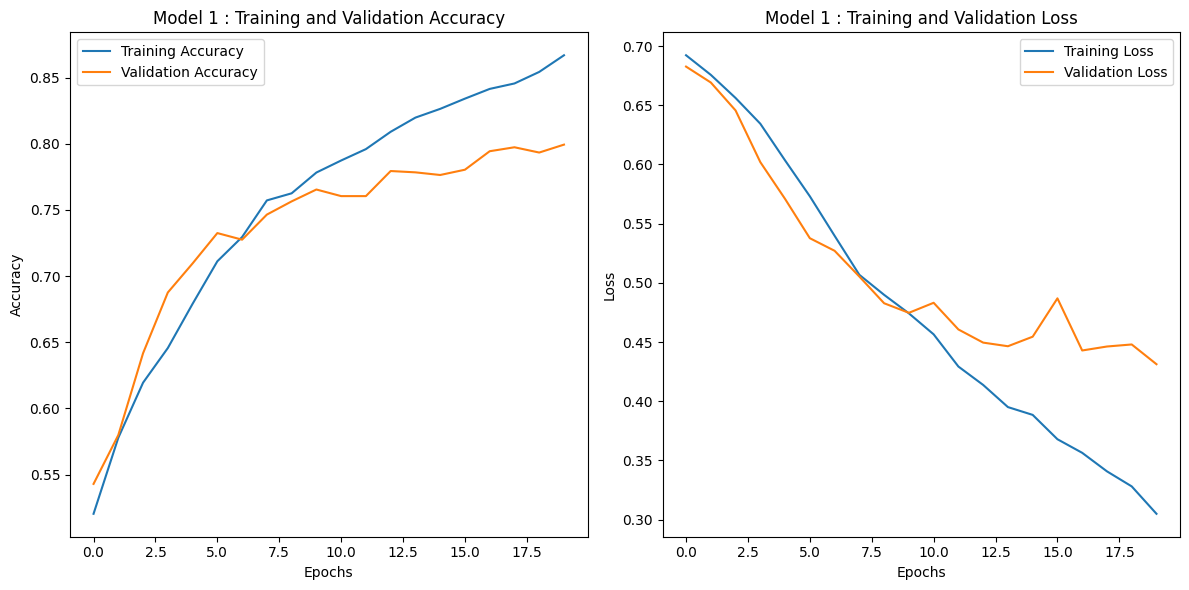

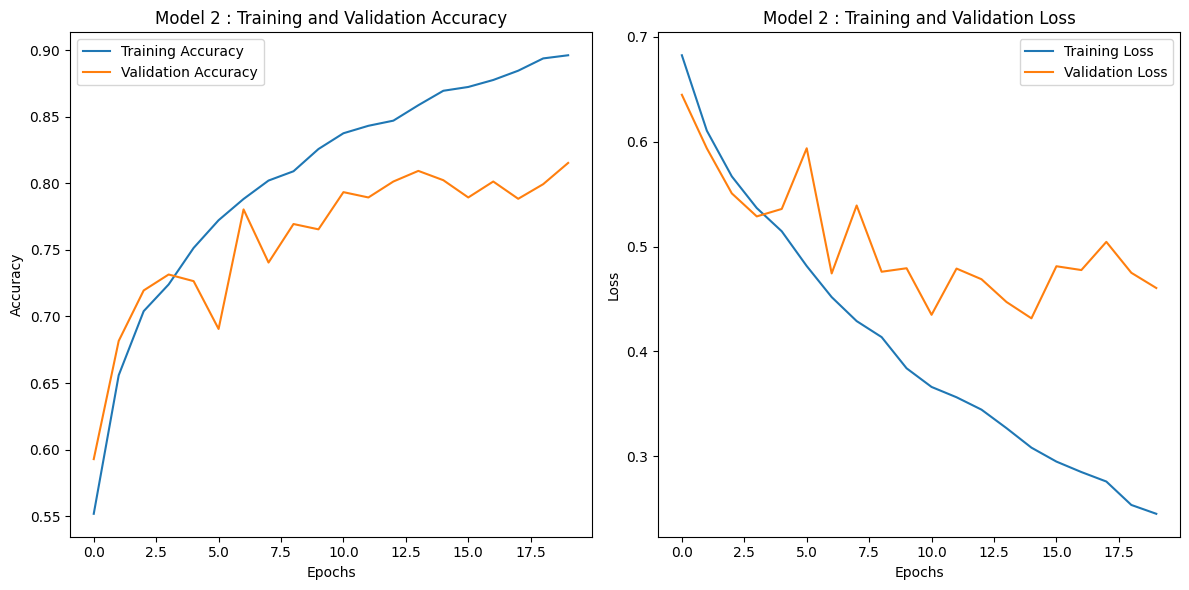

In [ ]:
plot_history(loaded_history_1, "Model 1")
plot_history(loaded_history_2, "Model 2")

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss_1, test_accuracy_1 = model_1.evaluate(test_data)
print(f'-> Model 1 - Test Accuracy: {test_accuracy_1}, Test Loss: {test_loss_1}')
test_loss_2, test_accuracy_2 = model_2.evaluate(test_data)
print(f'-> Model 2 - Test Accuracy: {test_accuracy_2}, Test Loss: {test_loss_2}')

34/34 [==============================] - 1s 22ms/step - loss: 0.4166 - accuracy: 0.8119
-> Model 1 - Test Accuracy: 0.8119403123855591, Test Loss: 0.4166207015514374
34/34 [==============================] - 1s 23ms/step - loss: 0.4357 - accuracy: 0.8179
-> Model 2 - Test Accuracy: 0.8179104328155518, Test Loss: 0.4357052147388458


In [ ]:
# Data augmentation

# On définit nos paramètres d'augmentation de données
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

# On applique l'augmentation des données (seulement sur le training set)
augmented_train_data  = train_data.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# Model creation

num_classes = 2

model_1 = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(128,4,input_shape=input_shape,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2 = keras.models.Sequential([
    layers.Rescaling(1./255),
    keras.layers.Conv2D(24, 5, input_shape=input_shape, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(48, 5, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(96, 5, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_classes, activation='softmax')
])

# model.build((None,) + input_shape)
# model.summary()

model_1.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_2.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
# Entrainement des deux modèles avec data augmenté

# history_1_augm = model_1.fit(
#     augmented_train_data,
#     validation_data = val_data,
#     workers=10,
#     epochs=40,
# )

# history_2_augm = model_2.fit(
#     augmented_train_data,
#     validation_data = val_data,
#     workers=10,
#     epochs=40,
# )

---

Epoch 1/40

268/268 [==============================] - 165s 611ms/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6895 - val_accuracy: 0.5729

Epoch 2/40

268/268 [==============================] - 164s 611ms/step - loss: 0.6827 - accuracy: 0.5547 - val_loss: 0.6597 - val_accuracy: 0.6028

Epoch 3/40

268/268 [==============================] - 162s 602ms/step - loss: 0.6625 - accuracy: 0.5958 - val_loss: 0.6315 - val_accuracy: 0.6377

Epoch 4/40

268/268 [==============================] - 161s 600ms/step - loss: 0.6356 - accuracy: 0.6398 - val_loss: 0.5979 - val_accuracy: 0.6796

Epoch 5/40

268/268 [==============================] - 160s 595ms/step - loss: 0.6225 - accuracy: 0.6536 - val_loss: 0.6049 - val_accuracy: 0.6727

Epoch 6/40

268/268 [==============================] - 160s 595ms/step - loss: 0.6104 - accuracy: 0.6728 - val_loss: 0.5845 - val_accuracy: 0.6607

Epoch 7/40

268/268 [==============================] - 163s 609ms/step - loss: 0.5969 - accuracy: 0.6858 - val_loss: 0.5599 - val_accuracy: 0.7206

Epoch 8/40

268/268 [==============================] - 162s 602ms/step - loss: 0.5900 - accuracy: 0.6849 - val_loss: 0.5734 - val_accuracy: 0.6986

Epoch 9/40

268/268 [==============================] - 162s 605ms/step - loss: 0.5726 - accuracy: 0.6998 - val_loss: 0.5581 - val_accuracy: 0.6966

Epoch 10/40

268/268 [==============================] - 163s 606ms/step - loss: 0.5762 - accuracy: 0.7015 - val_loss: 0.5300 - val_accuracy: 0.7305

Epoch 11/40

268/268 [==============================] - 162s 604ms/step - loss: 0.5663 - accuracy: 0.7050 - val_loss: 0.5336 - val_accuracy: 0.7275

Epoch 12/40

268/268 [==============================] - 163s 606ms/step - loss: 0.5604 - accuracy: 0.7167 - val_loss: 0.5287 - val_accuracy: 0.7265

Epoch 13/40

268/268 [==============================] - 163s 606ms/step - loss: 0.5589 - accuracy: 0.7091 - val_loss: 0.5253 - val_accuracy: 0.7365

Epoch 14/40

268/268 [==============================] - 162s 604ms/step - loss: 0.5472 - accuracy: 0.7207 - val_loss: 0.5099 - val_accuracy: 0.7405

Epoch 15/40

268/268 [==============================] - 161s 602ms/step - loss: 0.5380 - accuracy: 0.7299 - val_loss: 0.4992 - val_accuracy: 0.7665

Epoch 16/40

268/268 [==============================] - 160s 596ms/step - loss: 0.5235 - accuracy: 0.7399 - val_loss: 0.4972 - val_accuracy: 0.7655

Epoch 17/40

268/268 [==============================] - 164s 610ms/step - loss: 0.5298 - accuracy: 0.7305 - val_loss: 0.5871 - val_accuracy: 0.7216

Epoch 18/40

268/268 [==============================] - 162s 604ms/step - loss: 0.5263 - accuracy: 0.7375 - val_loss: 0.4822 - val_accuracy: 0.7595

Epoch 19/40

268/268 [==============================] - 166s 617ms/step - loss: 0.5116 - accuracy: 0.7414 - val_loss: 0.4820 - val_accuracy: 0.7635

Epoch 20/40

268/268 [==============================] - 162s 604ms/step - loss: 0.5098 - accuracy: 0.7481 - val_loss: 0.4750 - val_accuracy: 0.7605

Epoch 21/40

268/268 [==============================] - 164s 611ms/step - loss: 0.5080 - accuracy: 0.7517 - val_loss: 0.5334 - val_accuracy: 0.7575

Epoch 22/40

268/268 [==============================] - 162s 602ms/step - loss: 0.5052 - accuracy: 0.7540 - val_loss: 0.4423 - val_accuracy: 0.7914

Epoch 23/40

268/268 [==============================] - 163s 608ms/step - loss: 0.4859 - accuracy: 0.7630 - val_loss: 0.4522 - val_accuracy: 0.7804

Epoch 24/40

268/268 [==============================] - 161s 599ms/step - loss: 0.4866 - accuracy: 0.7632 - val_loss: 0.4288 - val_accuracy: 0.7944

Epoch 25/40

268/268 [==============================] - 163s 607ms/step - loss: 0.4778 - accuracy: 0.7716 - val_loss: 0.4268 - val_accuracy: 0.8004

Epoch 26/40

268/268 [==============================] - 163s 608ms/step - loss: 0.4794 - accuracy: 0.7681 - val_loss: 0.4047 - val_accuracy: 0.8074

Epoch 27/40

268/268 [==============================] - 164s 610ms/step - loss: 0.4736 - accuracy: 0.7707 - val_loss: 0.4190 - val_accuracy: 0.8024

Epoch 28/40

268/268 [==============================] - 163s 606ms/step - loss: 0.4709 - accuracy: 0.7764 - val_loss: 0.4058 - val_accuracy: 0.8184

Epoch 29/40

268/268 [==============================] - 161s 600ms/step - loss: 0.4551 - accuracy: 0.7852 - val_loss: 0.3854 - val_accuracy: 0.8204

Epoch 30/40

268/268 [==============================] - 165s 616ms/step - loss: 0.4487 - accuracy: 0.7879 - val_loss: 0.3999 - val_accuracy: 0.8164

Epoch 31/40

268/268 [==============================] - 163s 606ms/step - loss: 0.4389 - accuracy: 0.7950 - val_loss: 0.3846 - val_accuracy: 0.8184

Epoch 32/40

268/268 [==============================] - 161s 600ms/step - loss: 0.4420 - accuracy: 0.7944 - val_loss: 0.3788 - val_accuracy: 0.8164

Epoch 33/40

268/268 [==============================] - 160s 597ms/step - loss: 0.4278 - accuracy: 0.8052 - val_loss: 0.3869 - val_accuracy: 0.8114

Epoch 34/40

268/268 [==============================] - 160s 595ms/step - loss: 0.4291 - accuracy: 0.8030 - val_loss: 0.3660 - val_accuracy: 0.8363

Epoch 35/40

268/268 [==============================] - 158s 587ms/step - loss: 0.4323 - accuracy: 0.8014 - val_loss: 0.3773 - val_accuracy: 0.8283

Epoch 36/40

268/268 [==============================] - 157s 586ms/step - loss: 0.4210 - accuracy: 0.8089 - val_loss: 0.3442 - val_accuracy: 0.8433

Epoch 37/40

268/268 [==============================] - 161s 600ms/step - loss: 0.4156 - accuracy: 0.8105 - val_loss: 0.4057 - val_accuracy: 0.8124

Epoch 38/40

268/268 [==============================] - 159s 591ms/step - loss: 0.4092 - accuracy: 0.8163 - val_loss: 0.3952 - val_accuracy: 0.8383

Epoch 39/40

268/268 [==============================] - 160s 595ms/step - loss: 0.4133 - accuracy: 0.8094 - val_loss: 0.3491 - val_accuracy: 0.8403

Epoch 40/40

268/268 [==============================] - 158s 589ms/step - loss: 0.3978 - accuracy: 0.8236 - val_loss: 0.3264 - val_accuracy: 0.8503

---

---

On voit que à priori on peut continuer à entrainer le modèle sans overfitter. C'est donc ce que l'on va faire.

---

In [ ]:
# history_1_augm_second_part = model_1.fit(
#       augmented_train_data,
#       validation_data=val_data,
#       workers=10,
#       initial_epoch=40,
#       epochs=60,
# )

# # Sauvegarder les modèles
# template_file_1_augm_second_part = os.path.join(project_path, "models", f"model_1_augm_second_part")
# model_1.save(template_file_1_augm_second_part)

# # Sauvegarder les historiques
# history_file_1_augm_second_part = os.path.join(project_path, "models", f"history_1_augm_second_part.pkl")
# with open(history_file_1_augm_second_part, 'wb') as file:
#     pickle.dump(history_1_augm_second_part.history, file)

---

Epoch 41/60

268/268 [==============================] - 164s 607ms/step - loss: 0.4178 - accuracy: 0.8055 - val_loss: 0.3688 - val_accuracy: 0.8273

Epoch 42/60

268/268 [==============================] - 162s 604ms/step - loss: 0.3981 - accuracy: 0.8166 - val_loss: 0.3197 - val_accuracy: 0.8603

Epoch 43/60

268/268 [==============================] - 162s 604ms/step - loss: 0.3852 - accuracy: 0.8253 - val_loss: 0.3122 - val_accuracy: 0.8713

Epoch 44/60

268/268 [==============================] - 163s 608ms/step - loss: 0.3769 - accuracy: 0.8298 - val_loss: 0.3212 - val_accuracy: 0.8563

Epoch 45/60

268/268 [==============================] - 161s 599ms/step - loss: 0.3815 - accuracy: 0.8279 - val_loss: 0.3021 - val_accuracy: 0.8633

Epoch 46/60

268/268 [==============================] - 162s 604ms/step - loss: 0.3821 - accuracy: 0.8261 - val_loss: 0.3148 - val_accuracy: 0.8653

Epoch 47/60

268/268 [==============================] - 163s 606ms/step - loss: 0.3635 - accuracy: 0.8358 - val_loss: 0.3289 - val_accuracy: 0.8583

Epoch 48/60

268/268 [==============================] - 164s 610ms/step - loss: 0.3684 - accuracy: 0.8378 - val_loss: 0.3393 - val_accuracy: 0.8533

Epoch 49/60

268/268 [==============================] - 162s 604ms/step - loss: 0.3688 - accuracy: 0.8354 - val_loss: 0.3005 - val_accuracy: 0.8663

Epoch 50/60

268/268 [==============================] - 162s 605ms/step - loss: 0.3619 - accuracy: 0.8424 - val_loss: 0.2844 - val_accuracy: 0.8703

Epoch 51/60

268/268 [==============================] - 160s 595ms/step - loss: 0.3540 - accuracy: 0.8441 - val_loss: 0.2907 - val_accuracy: 0.8743

Epoch 52/60

268/268 [==============================] - 164s 611ms/step - loss: 0.3501 - accuracy: 0.8491 - val_loss: 0.3182 - val_accuracy: 0.8623

Epoch 53/60

268/268 [==============================] - 164s 612ms/step - loss: 0.3462 - accuracy: 0.8461 - val_loss: 0.2921 - val_accuracy: 0.8743

Epoch 54/60

268/268 [==============================] - 161s 599ms/step - loss: 0.3359 - accuracy: 0.8491 - val_loss: 0.2798 - val_accuracy: 0.8772

Epoch 55/60

268/268 [==============================] - 162s 603ms/step - loss: 0.3446 - accuracy: 0.8493 - val_loss: 0.2709 - val_accuracy: 0.8782

Epoch 56/60

268/268 [==============================] - 161s 602ms/step - loss: 0.3489 - accuracy: 0.8468 - val_loss: 0.2694 - val_accuracy: 0.8782

Epoch 57/60

268/268 [==============================] - 162s 605ms/step - loss: 0.3363 - accuracy: 0.8572 - val_loss: 0.2785 - val_accuracy: 0.8733

Epoch 58/60

268/268 [==============================] - 163s 608ms/step - loss: 0.3408 - accuracy: 0.8515 - val_loss: 0.2675 - val_accuracy: 0.8812

Epoch 59/60

268/268 [==============================] - 162s 603ms/step - loss: 0.3288 - accuracy: 0.8580 - val_loss: 0.2826 - val_accuracy: 0.8762

Epoch 60/60

268/268 [==============================] - 162s 603ms/step - loss: 0.3226 - accuracy: 0.8603 - val_loss: 0.2584 - val_accuracy: 0.8912

---

In [ ]:
!pip install scikeras

In [ ]:
history_1_augm_third_part = model_1.fit(
      augmented_train_data,
      validation_data=val_data,
      workers=10,
      initial_epoch=60,
      epochs=200,
)

# Sauvegarder les modèles
template_file_1_augm_third_part = os.path.join(project_path, "models", f"model_1_augm_third_part")
model_1.save(template_file_1_augm_third_part)

# Sauvegarder les historiques
history_file_1_augm_third_part = os.path.join(project_path, "models", f"history_1_augm_third_part.pkl")
with open(history_file_1_augm_third_part, 'wb') as file:
    pickle.dump(history_1_augm_third_part.history, file)

Epoch 61/200
268/268 [==============================] - 162s 600ms/step - loss: 0.3519 - accuracy: 0.8473 - val_loss: 0.2706 - val_accuracy: 0.8743
Epoch 62/200
268/268 [==============================] - 158s 590ms/step - loss: 0.3295 - accuracy: 0.8516 - val_loss: 0.3644 - val_accuracy: 0.8293
Epoch 63/200
268/268 [==============================] - 158s 588ms/step - loss: 0.3320 - accuracy: 0.8552 - val_loss: 0.2628 - val_accuracy: 0.8792
Epoch 64/200
268/268 [==============================] - 157s 587ms/step - loss: 0.3127 - accuracy: 0.8633 - val_loss: 0.2937 - val_accuracy: 0.8782
Epoch 65/200
268/268 [==============================] - 157s 586ms/step - loss: 0.3168 - accuracy: 0.8599 - val_loss: 0.2567 - val_accuracy: 0.8812
Epoch 66/200
268/268 [==============================] - 158s 588ms/step - loss: 0.3108 - accuracy: 0.8678 - val_loss: 0.2533 - val_accuracy: 0.8872
Epoch 67/200
268/268 [==============================] - 158s 590ms/step - loss: 0.3042 - accuracy: 0.8678 - val_

---

Epoch 61/200

268/268 [==============================] - 162s 600ms/step - loss: 0.3519 - accuracy: 0.8473 - val_loss: 0.2706 - val_accuracy: 0.8743

Epoch 62/200

268/268 [==============================] - 158s 590ms/step - loss: 0.3295 - accuracy: 0.8516 - val_loss: 0.3644 - val_accuracy: 0.8293

Epoch 63/200

268/268 [==============================] - 158s 588ms/step - loss: 0.3320 - accuracy: 0.8552 - val_loss: 0.2628 - val_accuracy: 0.8792

Epoch 64/200

268/268 [==============================] - 157s 587ms/step - loss: 0.3127 - accuracy: 0.8633 - val_loss: 0.2937 - val_accuracy: 0.8782

Epoch 65/200

268/268 [==============================] - 157s 586ms/step - loss: 0.3168 - accuracy: 0.8599 - val_loss: 0.2567 - val_accuracy: 0.8812

Epoch 66/200

268/268 [==============================] - 158s 588ms/step - loss: 0.3108 - accuracy: 0.8678 - val_loss: 0.2533 - val_accuracy: 0.8872

Epoch 67/200

268/268 [==============================] - 158s 590ms/step - loss: 0.3042 - accuracy: 0.8678 - val_loss: 0.2702 - val_accuracy: 0.8743

Epoch 68/200

268/268 [==============================] - 158s 588ms/step - loss: 0.3022 - accuracy: 0.8691 - val_loss: 0.2738 - val_accuracy: 0.8762

Epoch 69/200

268/268 [==============================] - 159s 592ms/step - loss: 0.3072 - accuracy: 0.8680 - val_loss: 0.2550 - val_accuracy: 0.8852

Epoch 70/200

268/268 [==============================] - 159s 594ms/step - loss: 0.3113 - accuracy: 0.8662 - val_loss: 0.2749 - val_accuracy: 0.8842

Epoch 71/200

268/268 [==============================] - 159s 591ms/step - loss: 0.3005 - accuracy: 0.8711 - val_loss: 0.2580 - val_accuracy: 0.8862

Epoch 72/200

268/268 [==============================] - 160s 598ms/step - loss: 0.2933 - accuracy: 0.8727 - val_loss: 0.2838 - val_accuracy: 0.8892

Epoch 73/200

268/268 [==============================] - 159s 591ms/step - loss: 0.2976 - accuracy: 0.8706 - val_loss: 0.2650 - val_accuracy: 0.8822

Epoch 74/200

268/268 [==============================] - 159s 594ms/step - loss: 0.2936 - accuracy: 0.8743 - val_loss: 0.2484 - val_accuracy: 0.8852

Epoch 75/200

268/268 [==============================] - 161s 600ms/step - loss: 0.2904 - accuracy: 0.8754 - val_loss: 0.2526 - val_accuracy: 0.8942

Epoch 76/200

268/268 [==============================] - 160s 598ms/step - loss: 0.2840 - accuracy: 0.8768 - val_loss: 0.2325 - val_accuracy: 0.8992

Epoch 77/200

268/268 [==============================] - 160s 597ms/step - loss: 0.2737 - accuracy: 0.8844 - val_loss: 0.2532 - val_accuracy: 0.8752

Epoch 78/200

268/268 [==============================] - 162s 605ms/step - loss: 0.2802 - accuracy: 0.8808 - val_loss: 0.2743 - val_accuracy: 0.8762

Epoch 79/200

268/268 [==============================] - 166s 619ms/step - loss: 0.2781 - accuracy: 0.8815 - val_loss: 0.2784 - val_accuracy: 0.8892

Epoch 80/200

268/268 [==============================] - 162s 605ms/step - loss: 0.2791 - accuracy: 0.8799 - val_loss: 0.2448 - val_accuracy: 0.8952

Epoch 81/200

268/268 [==============================] - 162s 603ms/step - loss: 0.2836 - accuracy: 0.8797 - val_loss: 0.2702 - val_accuracy: 0.8882

Epoch 82/200

268/268 [==============================] - 162s 603ms/step - loss: 0.2807 - accuracy: 0.8834 - val_loss: 0.2744 - val_accuracy: 0.8782

Epoch 83/200

268/268 [==============================] - 157s 587ms/step - loss: 0.2710 - accuracy: 0.8863 - val_loss: 0.2437 - val_accuracy: 0.8812

Epoch 84/200

268/268 [==============================] - 160s 598ms/step - loss: 0.2718 - accuracy: 0.8822 - val_loss: 0.2334 - val_accuracy: 0.8962

Epoch 85/200

268/268 [==============================] - 162s 603ms/step - loss: 0.2742 - accuracy: 0.8843 - val_loss: 0.3575 - val_accuracy: 0.8673

Epoch 86/200

268/268 [==============================] - 160s 597ms/step - loss: 0.2741 - accuracy: 0.8850 - val_loss: 0.2557 - val_accuracy: 0.8902

Epoch 87/200

268/268 [==============================] - 162s 602ms/step - loss: 0.2695 - accuracy: 0.8839 - val_loss: 0.2404 - val_accuracy: 0.8972

Epoch 88/200

268/268 [==============================] - 161s 600ms/step - loss: 0.2581 - accuracy: 0.8879 - val_loss: 0.2425 - val_accuracy: 0.8972

Epoch 89/200

268/268 [==============================] - 161s 599ms/step - loss: 0.2711 - accuracy: 0.8837 - val_loss: 0.2800 - val_accuracy: 0.8772

Epoch 90/200

268/268 [==============================] - 161s 600ms/step - loss: 0.2633 - accuracy: 0.8880 - val_loss: 0.2181 - val_accuracy: 0.9012

Epoch 91/200

268/268 [==============================] - 161s 601ms/step - loss: 0.2587 - accuracy: 0.8921 - val_loss: 0.2172 - val_accuracy: 0.9092

Epoch 92/200

268/268 [==============================] - 163s 606ms/step - loss: 0.2629 - accuracy: 0.8858 - val_loss: 0.2410 - val_accuracy: 0.8912

Epoch 93/200

268/268 [==============================] - 161s 601ms/step - loss: 0.2584 - accuracy: 0.8877 - val_loss: 0.2135 - val_accuracy: 0.9002

Epoch 94/200

268/268 [==============================] - 164s 610ms/step - loss: 0.2602 - accuracy: 0.8893 - val_loss: 0.2352 - val_accuracy: 0.8932

Epoch 95/200

268/268 [==============================] - 159s 592ms/step - loss: 0.2638 - accuracy: 0.8858 - val_loss: 0.2483 - val_accuracy: 0.9002

Epoch 96/200

268/268 [==============================] - 159s 592ms/step - loss: 0.2616 - accuracy: 0.8928 - val_loss: 0.2511 - val_accuracy: 0.9002

Epoch 97/200

268/268 [==============================] - 160s 597ms/step - loss: 0.2547 - accuracy: 0.8944 - val_loss: 0.2444 - val_accuracy: 0.8872

Epoch 98/200

268/268 [==============================] - 160s 596ms/step - loss: 0.2612 - accuracy: 0.8895 - val_loss: 0.2598 - val_accuracy: 0.8952

Epoch 99/200

268/268 [==============================] - 161s 601ms/step - loss: 0.2511 - accuracy: 0.8925 - val_loss: 0.2151 - val_accuracy: 0.9072

Epoch 100/200

268/268 [==============================] - 160s 595ms/step - loss: 0.2444 - accuracy: 0.9000 - val_loss: 0.2602 - val_accuracy: 0.8922

Epoch 101/200

268/268 [==============================] - 161s 601ms/step - loss: 0.2563 - accuracy: 0.8933 - val_loss: 0.2338 - val_accuracy: 0.8972

Epoch 102/200

268/268 [==============================] - 161s 600ms/step - loss: 0.2555 - accuracy: 0.8904 - val_loss: 0.2489 - val_accuracy: 0.8982

Epoch 103/200

268/268 [==============================] - 160s 596ms/step - loss: 0.2494 - accuracy: 0.8949 - val_loss: 0.2516 - val_accuracy: 0.8872

Epoch 104/200

268/268 [==============================] - 162s 603ms/step - loss: 0.2495 - accuracy: 0.8974 - val_loss: 0.2583 - val_accuracy: 0.8832

Epoch 105/200

268/268 [==============================] - 161s 599ms/step - loss: 0.2446 - accuracy: 0.8996 - val_loss: 0.2343 - val_accuracy: 0.9042

Epoch 106/200

268/268 [==============================] - 162s 604ms/step - loss: 0.2375 - accuracy: 0.8969 - val_loss: 0.2175 - val_accuracy: 0.9072

Epoch 107/200

268/268 [==============================] - 162s 603ms/step - loss: 0.2375 - accuracy: 0.8998 - val_loss: 0.2192 - val_accuracy: 0.9032

Epoch 108/200

268/268 [==============================] - 162s 603ms/step - loss: 0.2423 - accuracy: 0.8981 - val_loss: 0.2187 - val_accuracy: 0.9032

Epoch 109/200

268/268 [==============================] - 161s 601ms/step - loss: 0.2365 - accuracy: 0.9030 - val_loss: 0.2220 - val_accuracy: 0.9032

Epoch 110/200

268/268 [==============================] - 161s 599ms/step - loss: 0.2367 - accuracy: 0.9010 - val_loss: 0.2192 - val_accuracy: 0.9052

Epoch 111/200

268/268 [==============================] - 161s 599ms/step - loss: 0.2347 - accuracy: 0.9040 - val_loss: 0.2406 - val_accuracy: 0.8952

Epoch 112/200

268/268 [==============================] - 161s 599ms/step - loss: 0.2387 - accuracy: 0.9001 - val_loss: 0.2136 - val_accuracy: 0.9152

Epoch 113/200

268/268 [==============================] - 161s 598ms/step - loss: 0.2372 - accuracy: 0.9007 - val_loss: 0.2191 - val_accuracy: 0.9062

Epoch 114/200

268/268 [==============================] - 162s 602ms/step - loss: 0.2264 - accuracy: 0.9052 - val_loss: 0.2154 - val_accuracy: 0.9072

Epoch 115/200

268/268 [==============================] - 160s 597ms/step - loss: 0.2251 - accuracy: 0.9054 - val_loss: 0.2480 - val_accuracy: 0.9032

Epoch 116/200

268/268 [==============================] - 161s 600ms/step - loss: 0.2334 - accuracy: 0.9040 - val_loss: 0.1906 - val_accuracy: 0.9062

Epoch 117/200

268/268 [==============================] - 160s 597ms/step - loss: 0.2321 - accuracy: 0.9037 - val_loss: 0.2173 - val_accuracy: 0.9002

---

In [ ]:
# # Sauvegarder les modèles
# template_file_1_augm = os.path.join(project_path, "models", f"model_1_augm")
# model_1.save(template_file_1_augm)
# template_file_2_augm = os.path.join(project_path, "models", f"model_2_augm")
# model_2.save(template_file_2_augm)

# # Sauvegarder les historiques
# history_file_1_augm = os.path.join(project_path, "models", f"history_1_augm.pkl")
# with open(history_file_1_augm, 'wb') as file:
#     pickle.dump(history_1_augm.history, file)
# history_file_2_augm = os.path.join(project_path, "models", f"history_2_augm.pkl")
# with open(history_file_2_augm, 'wb') as file:
#     pickle.dump(history_2_augm.history, file)

In [ ]:
# Charger les modèles
template_file_1_augm = os.path.join(project_path, "models", f"model_1_augm_second_part") # model_1_augm / model_1_augm_second_part
model_1 = load_model(template_file_1_augm)
# template_file_2_augm = os.path.join(project_path, "models", f"model_2_augm")
# model_2 = load_model(template_file_2_augm)

# Charger les historiques
history_file_1_augm = os.path.join(project_path, "models", f"history_1_augm_second_part.pkl") # history_1_augm / history_1_augm_second_part
with open(history_file_1_augm, 'rb') as file:
    loaded_history_1_augm = pickle.load(file)
# history_file_2_augm = os.path.join(project_path, "models", f"history_2_augm.pkl")
# with open(history_file_2_augm, 'rb') as file:
#     loaded_history_2_augm = pickle.load(file)

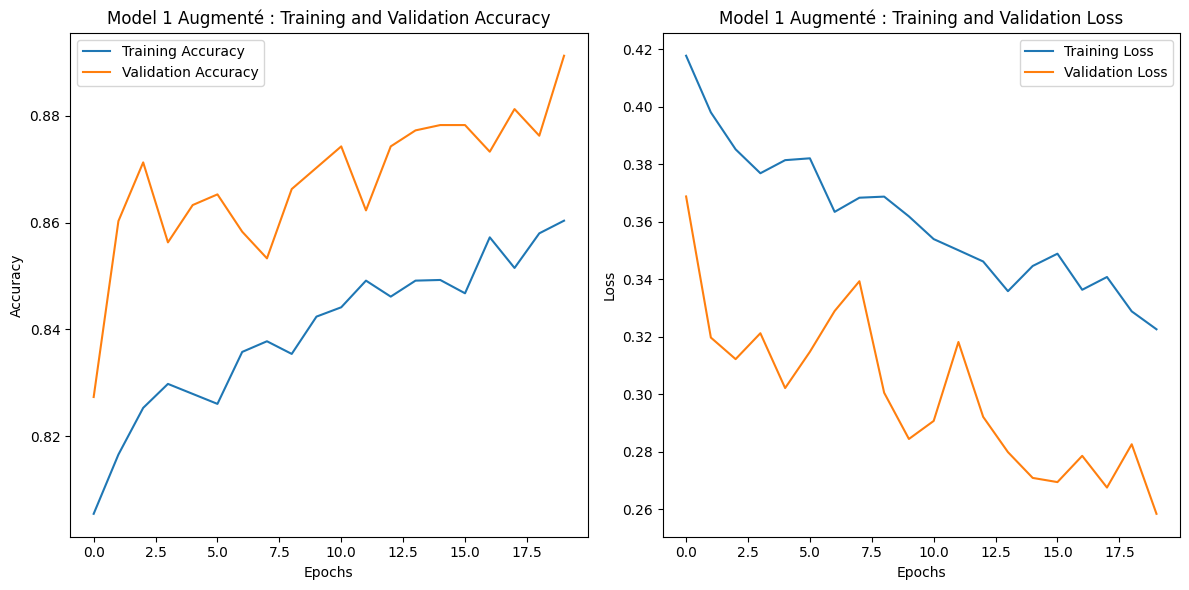

In [ ]:
plot_history(loaded_history_1_augm, "Model 1 Augmenté")
# plot_history(loaded_history_2_augm, "Model 2 Augmenté")